# Optimisation : Placer la plus grande maison possible dans un terrain

- La maison est un rectangle
- Le terrain est un polygone quelconque, il peut être convexe ou concave
- L'optimisation peut être faite en utilisant les algorithmes PSO, DE ou ABC

In [1]:
from sympy.geometry import Point
from sympy.geometry import Polygon as SympyPolygon
from scipy import *
from math import *
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pyclipper
import functools

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Class and converting functions

In [2]:
class Rectangle:
    """Minimal representation of a rectangle"""
    def __init__(self, point1_x, point1_y, point2_x, point2_y, longueur):
        self.point1_x = point1_x
        self.point1_y = point1_y
        self.point2_x = point2_x
        self.point2_y = point2_y
        self.longueur = longueur
        
    def side_length(self):
        return dist((self.point1_x, self.point1_y), (self.point2_x, self.point2_y))
    
    def area(self):
        return abs(self.side_length() * self.longueur)
    
    def to_rect(self, strategy="Default"):
        """Convert a minimal rectangle to a full rectangle"""
        vect = (self.point2_x - self.point1_x, self.point2_y - self.point1_y)
        distance = self.side_length()
        vectUnitaire = (vect[0] / distance * self.longueur, vect[1] / distance * self.longueur)
        normalVect = (-vectUnitaire[1], vectUnitaire[0])
        point1 = (self.point1_x, self.point1_y)
        point2 = (self.point2_x, self.point2_y)
        point3 = (self.point2_x + normalVect[0], self.point2_y + normalVect[1])
        point4 = (self.point1_x + normalVect[0], self.point1_y + normalVect[1])
        if strategy == "Default":
            return [point1, point2, point3, point4]
        else:
            return SimpyPolygon(point1, point2, point3, point4)
      
    def is_valid(self, polygon, verbose=False):
        """ Determine if the rectangle is in the polygon

        @param polygon: whether a polygon or a list of vertices
        """
        if verbose:
            print("entrée: est_valide")
            start_time = time.time()
        try:
            rectangle = self.to_rect()
            pc = pyclipper.Pyclipper()
            pc.AddPath(polygon, pyclipper.PT_CLIP, True)
            pc.AddPath(rectangle, pyclipper.PT_SUBJECT, True)

            intersections = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)

            res = (intersections != []) and (len(intersections[0]) == len(rectangle)) and np.all([vertice_in_polygon(v, intersections[0]) for v in rectangle]) 
            if verbose:
                print("--- %s seconds ---" % (time.time() - start_time))
            return res
        except pyclipper.ClipperException:
            print("Clipper exception")
            return False

### Util functions

In [3]:
def vertice_in_polygon(vertice, polygon):
    """ Determine if the vertice is in the polygon
    Not a strict check because of the pyclipper library in which
    the coordinates are floored.
    """
    x, y = vertice
    x, y = int(x), int(y)
    return [x,y] in polygon

## Drawing functions

In [4]:
def draw_polygon(polygon, ax=None, color="green"):
    """Draw a polygon over an axis (not shown directly)
    
    @param polygon: Whether a polygon or a path
    """
    if ax is None:
        ax = plt.gca()
    if type(polygon) == SympyPolygon:
        polygon = np.array(list(map(lambda p: [p.x, p.y], polygon.vertices)))
    p = Polygon(polygon, closed=False, color=color, alpha=0.3, lw=0)
    ax.add_patch(p)
    ax.axis('equal')
    return ax

def draw_polygons(polygons, colors=None, verbose=False):
    """Draw polygons and print the figure
    
    @param polygons: SimpyPolygon or list(SimpyPolygon)
    @param colors: colors to match to the polygons
    """
    ax = plt.gca()
    if type(polygons) == SympyPolygon:
        polygons = [polygons]
    if colors is None:
        colors = ["grey"]*len(polygons)
    if len(colors) > 0 and len(colors) < len(polygons):
        colors = colors + [colors[-1]] * (len(polygons) - len(colors))
    colors.reverse()
    
    for polygon in polygons:
        color = colors.pop()
        if verbose:
            print(color, "Polygon : ", polygon)
        ax = draw_polygon(polygon, ax, color=color)
    plt.show()

## Lambda functions to use in the calls

### Logger function

In [5]:
def log_polygons(land, sols, colors=["green", "brown"], legend="Best", padding=1, iteration=0):
    if (iteration % padding == 0):
        sols = list(sols) if type(sols) == map else [sols]
        legend_text = " : " + legend if legend is not None else ""
        printmd("### Itération "+str(iteration)+legend_text)
        polygons = [land]+[Rectangle(*sol).to_rect() for sol in sols]
        draw_polygons(polygons, colors)

### Bornage function

In [6]:
def polygon_bounding(sol, land_polygon, verbose=False):
    if verbose:
        print("entrée: polygon_bornage")
    solution = Rectangle(*sol)
    if solution.is_valid(land_polygon):
        if verbose:
            print(sol)
            printmd("## Est valide")
        return sol 
    else:
        if verbose:
            print("this one is invalid")
        # print(sol)
        raise ValueError("Solution invalide par contrainte de bornage")

## Initialization function

In [68]:
from sympy import Symbol
def pick_random_sol(land, size=1, delta=0.05, stochastic=False, strategy="random"):
    if strategy == "random":
        sols = []
        for _ in range(size):
            sol = random.uniform(0,100,5)
            rect = Rectangle(*sol)
            while not rect.is_valid(land):
                sol = random.uniform(0,100,5)
                rect = Rectangle(*sol)
            sols.append(sol)
        return sols
    else:
        t = Symbol('t', real=True)
        p = SympyPolygon(*land).arbitrary_point('t')
        if stochastic:
            picks = sorted([random.rand() for i in range(size*2)])
        else:
            picks = np.linspace(0, 1, size*2+1)
        points_on_perimeter = [p.subs(t, pick) for pick in picks]
        sols = [[points_on_perimeter[i*2].x, points_on_perimeter[i*2].y, points_on_perimeter[i*2+1].x, points_on_perimeter[i*2+1].y, -10-delta*2000*random.rand()] for i in range(size)]
        for sol in sols:
            while not Rectangle(*sol).is_valid(land):
                sol[4] = sol[4] / 2
        return sols

# Main

In [51]:
poly1 = [(0,0), (0,100), (100,100), (110, 50), (100, 0)]
poly2 = [(0,0), (0,100), (30,90), (30,40), (71,25), (71,100), (100,100), (100,0)]
poly3 = [(0,0), (0,100), (30,90), (30,10), (71,25), (71,100), (100,100), (100,0)]

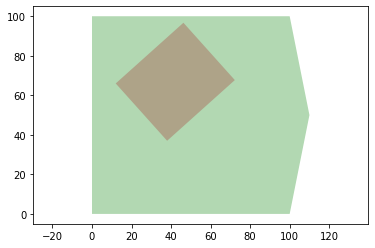

### Validité : C'est bon ça passe

### L'aire de la maison est de **1791** m² sur 10500 m² possible



In [52]:
house = Rectangle(12, 66, 38, 37, 46)
land = poly1

# draw the situation
draw_polygons([land, house.to_rect()], colors=["green", "brown"], verbose=False)

# determine if the house is well placed over the land
res = house.is_valid(land)
printmd("### Validité : C'est bon ça passe" if res else "### Validité : Noooooooon, construction incorrecte")
printmd(f"### L'aire de la maison est de **{int(house.area())}** m² sur {abs(SympyPolygon(*land).area)} m² possible\n\n")

In [53]:
from ipynb.fs.full.PSO import fit as PSO_fit

### Itération 0 : Initialization

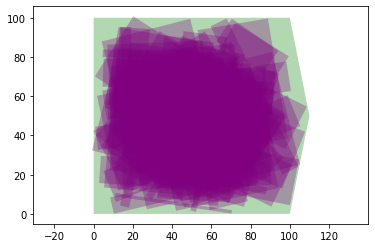

 16%|█▌        | 160/1000 [00:00<00:03, 224.48it/s]

Clipper exception


 23%|██▎       | 227/1000 [00:01<00:03, 220.78it/s]

### Itération 250 : Swarm

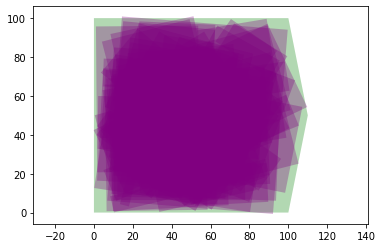

### Itération 250 : Best = **8131**

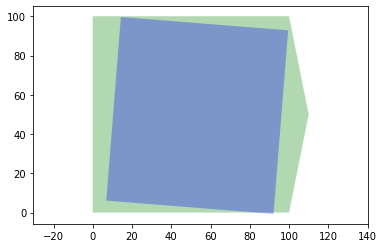

 50%|████▉     | 498/1000 [00:02<00:02, 215.99it/s]

### Itération 500 : Swarm

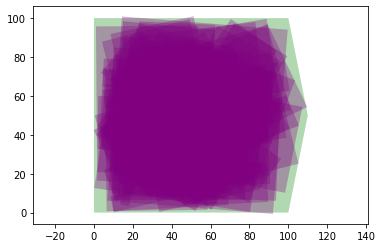

### Itération 500 : Best = **8131**

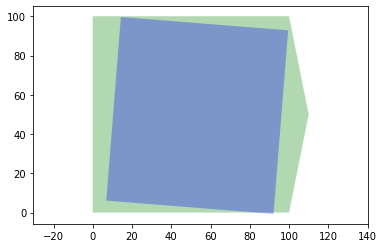

 74%|███████▍  | 739/1000 [00:03<00:01, 211.43it/s]

Clipper exception
Clipper exception


### Itération 750 : Swarm

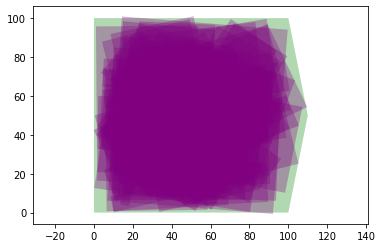

### Itération 750 : Best = **8131**

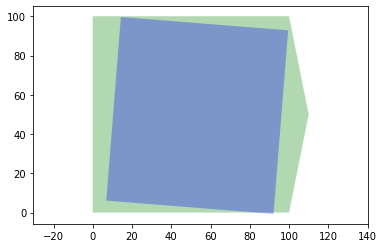

 82%|████████▎ | 825/1000 [00:04<00:01, 162.76it/s]

Clipper exception
Clipper exception


 94%|█████████▎| 936/1000 [00:05<00:00, 204.86it/s]

Clipper exception


 98%|█████████▊| 981/1000 [00:05<00:00, 212.22it/s]

### Itération 1000 : Swarm

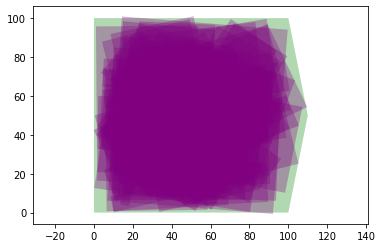

### Itération 1000 : Best = **8131**

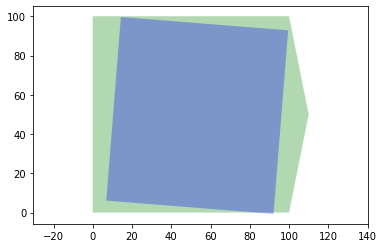

100%|██████████| 1000/1000 [00:05<00:00, 171.44it/s]


### Itération 1000 : Best final = **8131**

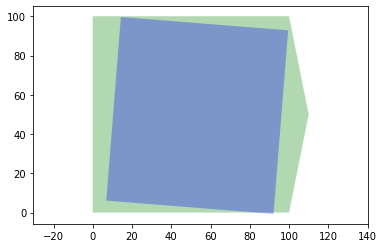

In [74]:
dim = 5
nb_particle = 100
nb_cycles = 1000
psi, cmax = 0.7, 1.47

log_padding = 250

eval_function = lambda x: Rectangle(*x).area()
bounding_function = lambda x: polygon_bounding(x, land)
log_function = lambda x,it=0,legend=None,padding=log_padding,colors=["green", "red"]:log_polygons(land, x, colors, legend, padding, it)
init_function = lambda nb: pick_random_sol(land, nb)
isbetter_function = lambda f1, f2: f1 > f2

best_sol, logs = PSO_fit(eval_function=eval_function, 
    bounding_function=bounding_function, 
    log_function=log_function,
    init_function=init_function,
    isbetter_function=isbetter_function,
    nb_particle=nb_particle, 
    dim=dim, 
    nb_cycles=nb_cycles,
    psi=psi,
    cmax=cmax)

In [75]:
printmd("### Solution")
print([int(x) for x in best_sol['pos']], "Fitness =", best_sol['fit'])

printmd("### Sommets du rectangle solution")
best_sol_rect = Rectangle(*best_sol['pos']).to_rect()
print([(int(x), int(y)) for (x,y) in best_sol_rect])

### Solution

[6, 6, 92, 0, 93] Fitness = 8019.289538103355


### Sommets du rectangle solution

[(6, 6), (92, 0), (99, 92), (14, 99)]


In [45]:
import pyswarms as ps

def cost_rectangle_func(swarm_positions):
    rects = [Rectangle(*particule) for particule in swarm_positions]
    return [-rect.area() if rect.is_valid(land) else rect.area() for rect in rects]
    
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=5, options=options)
# Perform optimization
best_cost, best_pos = optimizer.optimize(cost_rectangle_func, iters=1000)

2020-12-02 23:37:13,421 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   7%|▋         |67/1000, best_cost=-2.33e+3

Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper exception
Clipper ex

pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-2.94e+3
2020-12-02 23:37:15,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2943.9999999999973, best pos: [-1. 91. -1. -1. 32.]


### Itération 0 : Best

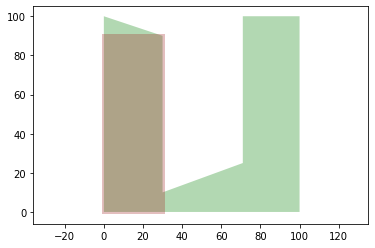

-2943.9999999999973
[(0, 91), (0, 0), (30, 0), (30, 90)]


In [46]:
log_polygons(land, best_pos, colors=["green", "brown"])
print(best_cost)
print([(int(x), int(y)) for (x,y) in Rectangle(*best_pos).to_rect()])

In [ ]:
# from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
# from IPython.display import HTML

# # Plot the cost
# plot_cost_history(optimizer.cost_history)
# plt.show()

# from pyswarms.utils.plotters.formatters import Mesher, Designer
# # Plot the sphere function's mesh for better plots
# min_lim, max_lim = -1,1
# m = Mesher(func=cost_rectangle_func,
#            limits=[(min_lim,max_lim),(min_lim,max_lim),(min_lim,max_lim),(min_lim,max_lim),(min_lim,max_lim)])
# # Adjust figure limits
# d = Designer(limits=[(min_lim,max_lim),(min_lim,max_lim),(min_lim,max_lim),(min_lim,max_lim),(min_lim,max_lim)],
#              label=['x-axis', 'y-axis', 'z-axis', 'w-axis', 'v-axis'])

# anim = plot_contour(pos_history=optimizer.pos_history, mesher=m, designer=d, mark=(0,0,0,0,0))
# HTML(anim.to_html5_video())

# pos_history_3d = m.compute_history_3d(optimizer.pos_history) # preprocessing
# animation3d = plot_surface(pos_history=pos_history_3d,
#                            mesher=m, designer=d,
#                            mark=(0,0,0))

# HTML(animation3d.to_html5_video())